In [24]:
from __future__ import print_function
import importlib
resources = importlib.import_module("resources")
import resources.MonteCarlo as MC

import numpy as np
import pandas as pd
import random
my_seed = 2010
random.seed(my_seed)

import matplotlib.pyplot as plt
%matplotlib inline 

from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler


import keras
import tensorflow as tf
from keras.layers import Dense, BatchNormalization, Multiply, Lambda, LeakyReLU
from keras.models import Model
from keras.initializers import RandomNormal, RandomUniform
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.constraints import NonNeg
from keras import backend as K

In [25]:
normalization_const = 1e6

#Import Data
Data = pd.read_csv('data/preprocessedlosAngParking/part-00000-a8814381-7490-4ac5-8769-145ad7e2824a-c000.csv').sample(frac = 1/5e3)
Data['SN'] = pd.to_numeric(Data['SN'], errors ='coerce')
Data['position'] = pd.to_numeric(Data['position'], errors ='coerce')
Data.dropna()
Data = Data[Data['SN'] > 1.3e9]
Data = Data/normalization_const
X = Data['SN'].values
Y = Data['position'].values

In [42]:

batch_size = 256
no_input  = 1
epochs = 30000
lambd  = 1e-6

results = {}
models  = []
no_output_range = range(1,9,2)
def customLoss(yTrue,yPred):
    #return K.sum(K.square(yTrue-yPred))
    return K.sum(K.min(K.square(yTrue - yPred),axis = 1))\
    +lambd*K.sum(K.square(yTrue-yPred))

def customMetric(yTrue,yPred):
    #return K.sum(K.square(yTrue-yPred))
    return K.max(K.min(K.abs(yTrue -yPred),axis = 1))

for no_output in no_output_range:
    Y_TRANSFORMED = np.repeat(Y.reshape((Y.shape[0],1)),no_output,axis=1)
    
    _input_= keras.layers.Input(shape=(no_input,))
    
    neg_pos_mask = tf.constant(np.random.choice( [-1,1],[1,no_output]),dtype = tf.float32)
    mask = Lambda( lambda x : neg_pos_mask)(_input_) # _input_ is just added to get this to compile
    
    l1 = Dense(64, activation='linear', name="hidden_1_dense64",
                    kernel_initializer= RandomUniform(minval=1, maxval=2),
                    bias_initializer=RandomUniform(), kernel_constraint=NonNeg(),                   
                    input_shape=[no_input])(_input_)
    l1a =keras.layers.LeakyReLU(alpha=0.1,name="hidden_1_leakyRelu")(l1)
    l1b = BatchNormalization(gamma_constraint=NonNeg(), name='batch_norm_1')(l1a)
    
    l2 = Dense(32, activation='linear', name="hidden_2_dense64",
                    kernel_initializer=RandomUniform(minval=1, maxval=2),
                    bias_initializer=RandomUniform(), kernel_constraint=NonNeg())(l1b)
    l2a =keras.layers.LeakyReLU(alpha=0.1,name="hidden_2_leakyRelu")(l2)
    l2a = l2
    l2b = BatchNormalization(gamma_constraint=NonNeg(), name='batch_norm_2')(l2a)

    l3 = Dense(32, activation='relu', name="hidden_3_dense64",
                    kernel_initializer=RandomUniform(minval=.05, maxval=.15),
                    bias_initializer=RandomUniform(), kernel_constraint=NonNeg())(l2b)
    l3a =keras.layers.LeakyReLU(alpha=0.1,name="hidden_3_leakyRelu")(l2)
    l3a = l3
    l3b = BatchNormalization(gamma_constraint=NonNeg(), name='batch_norm_3')(l3a)

    l4 = Dense(no_output, activation='linear', name="hidden_4_dense64",
                    kernel_initializer=RandomUniform(minval=.05, maxval=1),
                    bias_initializer= RandomNormal(), kernel_constraint=NonNeg())(l3b)

    #_output_ =l3
    _output_ = Multiply()([l4,mask])
    
    model = keras.models.Model(inputs=_input_ , outputs=_output_)
    filepath = "results\parking_weights{}.hdf5".format(no_output)
    checkpoint = ModelCheckpoint(filepath, monitor="val_customMetric", verbose=0, period = 100, mode = 'min', save_best_only=True)
    model.compile(loss=customLoss, metrics=[customMetric],
                  optimizer=keras.optimizers.Nadam(lr=.01, beta_1=0.9, beta_2=0.999, clipvalue=0.5, schedule_decay=0.0001))
    model.fit(X, Y_TRANSFORMED,
              batch_size=batch_size,
              epochs=epochs,
              validation_data=(X, Y_TRANSFORMED),
              callbacks=[checkpoint],
              verbose=0)
    model.load_weights(filepath)    
    score = model.evaluate(X, Y_TRANSFORMED, verbose=0)
    print(score)
    YPred= model.predict(X)
    maxError = np.max(np.min(np.abs(YPred - Y_TRANSFORMED),axis=1),axis=0)
    results[no_output] = maxError
    models.append(model)
print(results)

[2222.6875995952732, 4.29402876531461]
[27.861462158129676, 1.4131908102586381]
[3.891180279452878, 0.8586386498131047]
[1.1770754622208082, 0.6711216988546324]
{1: 4.527386805175782, 3: 1.4959609543991088, 5: 0.9116474077148435, 7: 0.7116716837463377}


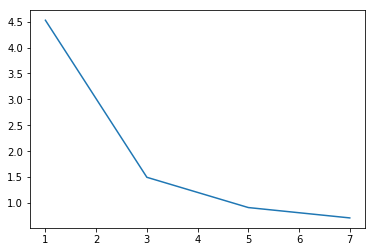

In [43]:
plt.plot(results.keys(),results.values())

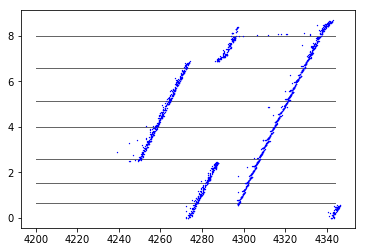

In [44]:
X_space = np.linspace(4200, 4344, 400)
#Y1,Y2 = zip(*model.predict(X))
i = 0 
for model in models:
    plt.clf()
    model_output_linspace = zip(*model.predict(X_space))

    plt.scatter(X, Y,s = .2, c='blue',marker= '^',zorder=2)
    #plt.scatter(x_test, y_test, s = .2 ,c='black',zorder=2)

    for Y_pred in model_output_linspace:
        line, = plt.plot(X_space,Y_pred, 'k',linewidth = 1, alpha = .6,zorder=1)
        line.set_color("black")
    #plt.plot(X,Y3, 'b-',)
    #plt.plot(X,Y4, 'y-',linewidth = 3)

    # Add title and x, y labels
    plt.savefig("results/Test_Parking_{number}.jpg".format(number = no_output_range[i]))
    i+=1


In [17]:
Z = model.predict(X)
print(Z)

[[0.43125924]
 [0.43126008]
 [0.43126005]
 [0.4312603 ]
 [0.43126032]
 [0.43125966]
 [0.43126032]
 [0.43125978]
 [0.43126032]
 [0.4312596 ]
 [0.43125996]
 [0.4312602 ]
 [0.43125987]
 [0.43125954]
 [0.43125993]
 [0.43125948]
 [0.43125993]
 [0.4312593 ]
 [0.43125936]
 [0.43125948]
 [0.4312596 ]
 [0.43125945]
 [0.43126005]
 [0.43126002]
 [0.43125954]
 [0.43125933]
 [0.43125957]
 [0.43126017]
 [0.43126017]
 [0.43125948]
 [0.43126026]
 [0.4312594 ]
 [0.43125948]
 [0.4312602 ]
 [0.43126005]
 [0.4312594 ]
 [0.43125933]
 [0.43125954]
 [0.43125972]
 [0.43125942]
 [0.43126005]
 [0.43125984]
 [0.4312595 ]
 [0.43125966]
 [0.43125975]
 [0.43126032]
 [0.4312594 ]
 [0.43125936]
 [0.43125924]
 [0.43126014]
 [0.43126032]
 [0.43126014]
 [0.43125942]
 [0.43126008]
 [0.43125954]
 [0.43126023]
 [0.4312603 ]
 [0.43125954]
 [0.4312597 ]
 [0.43126017]
 [0.4312593 ]
 [0.43125984]
 [0.4312601 ]
 [0.4312595 ]
 [0.43126008]
 [0.43125984]
 [0.43125936]
 [0.43125933]
 [0.4312601 ]
 [0.43125927]
 [0.43125987]
 [0.43

In [18]:
for layer in model.layers:
    g=layer.get_config()
    h=layer.get_weights()
    print(g)
    print(h)

{'batch_input_shape': (None, 1), 'dtype': 'float32', 'sparse': False, 'name': 'input_10'}
[]
{'name': 'hidden_1_dense64', 'trainable': True, 'batch_input_shape': (None, 1), 'dtype': 'float32', 'units': 64, 'activation': 'linear', 'use_bias': True, 'kernel_initializer': {'class_name': 'RandomNormal', 'config': {'mean': 0.0, 'stddev': 0.05, 'seed': None}}, 'bias_initializer': {'class_name': 'Zeros', 'config': {}}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': {'class_name': 'NonNeg', 'config': {}}, 'bias_constraint': None}
[array([[-0.        , -0.        , -0.        , -0.        , -0.        ,
        -0.        , -0.        ,  0.01168649, -0.        , -0.        ,
        -0.        , -0.        , -0.        , -0.        , -0.        ,
        -0.        , -0.        , -0.        , -0.        , -0.        ,
        -0.        , -0.        , -0.        , -0.        , -0.        ,
         0.04955024, -0.        , -0.        , -

In [44]:
Z = model.predict(X)
n = Z.shape[1]
def TestcustomMetric(yTrue,yPred):
    #return K.sum(K.square(yTrue-yPred))
    return np.max(np.min(np.abs(np.repeat(yTrue.reshape((Y.shape[0],1)),n,axis=1) -yPred),axis = 1))

TestcustomMetric(Y,Z)

0.08670679124336245

In [18]:
np.max(np.min(np.abs(Y-model.predict(X).transpose()),axis =0))


0.8146390024841309

In [30]:
Z

array([[0.54177535, 0.05803883, 0.70395744, 0.13071795],
       [0.35115886, 0.05803828, 0.4772023 , 0.05458892],
       [0.5713086 , 0.05803892, 0.7390927 , 0.14251326],
       [0.5250598 , 0.05803878, 0.6840713 , 0.12404196],
       [0.84392405, 0.0580396 , 1.0217736 , 0.9784222 ],
       [0.4550112 , 0.05803858, 0.60073566, 0.09606522],
       [0.5876761 , 0.05803896, 0.75856483, 0.14905028],
       [0.7915473 , 0.05803948, 0.97123957, 0.81926876],
       [0.38559413, 0.05803838, 0.5181514 , 0.06834071],
       [0.5708701 , 0.05803892, 0.73857105, 0.14233816],
       [0.5381377 , 0.05803882, 0.6996299 , 0.12926514],
       [0.5450075 , 0.05803884, 0.7078027 , 0.13200888],
       [0.575905  , 0.05803893, 0.74456096, 0.14434901],
       [0.7225096 , 0.05803932, 0.90299976, 0.60361284],
       [0.5256804 , 0.05803879, 0.68480957, 0.1242898 ],
       [0.51798093, 0.05803876, 0.67564964, 0.1212147 ],
       [0.4810058 , 0.05803866, 0.631661  , 0.10644722],
       [0.60748273, 0.05803902,